# Tvorba strukturovaných sítí

In [1]:
using PyPlot;

In [2]:
function channel(n,m)
    x = zeros(n,m);  y = zeros(n,m)
    
    x[1,:] = 0.0; y[1,:] = linspace(0,1,m)
    x[n,:] = 3.0; y[n,:] = linspace(0,1,m)
    x[:,m] = linspace(0,3,n); y[:,m] = 1.0
    
    length = 2 + π/2
    ds = length / (n-1)
    for i in 1:n
        s = (i-1) * ds
        if s < 1   
            x[i,1] = s; y[i,1] = 0;
        elseif s < 1 + π/2
            ϕ = 2*(s - 1)
            x[i,1] = 1.5 - 0.5*cos(ϕ)
            y[i,1] = 0.5*sin(ϕ)
        else
            x[i,1] = s + 1 - π/2; y[i,1] = 0
        end
    end
    return x,y
end

channel (generic function with 1 method)

In [3]:
function channel_ns(n,m)
    x = zeros(n,m);  y = zeros(n,m)
    
    x[1,:] = 0.0; y[1,:] = linspace(0,1,m).^3
    x[n,:] = 3.0; y[n,:] = linspace(0,1,m).^3
    x[:,m] = linspace(0,3,n); y[:,m] = 1.0
    
    length = 2 + π/2
    ds = length / (n-1)
    for i in 1:n
        s = (i-1) * ds
        if s < 1   
            x[i,1] = s; y[i,1] = 0;
        elseif s < 1 + π/2
            ϕ = 2*(s - 1)
            x[i,1] = 1.5 - 0.5*cos(ϕ)
            y[i,1] = 0.5*sin(ϕ)
        else
            x[i,1] = s + 1 - π/2; y[i,1] = 0
        end
    end
    return x,y
end

channel_ns (generic function with 1 method)

In [4]:
function curved_rectangle(n,m)
    x = zeros(n,m);  y = zeros(n,m)
    
    x[:,1] = linspace(0,1,n)
    y[:,1] = (x[:,1] - 0.5).^2/2 - 0.125

    x[:,end] = linspace(0,1,n)
    y[:,end] = 1.125 - (x[:,1] - 0.5).^2/2

    y[1,:] = linspace(0,1,m)
    x[1,:] = 0.125 - (y[1,:] - 0.5).^2/2

    y[end,:] = linspace(0,1,m)
    x[end,:] = 1.125 - (y[end,:] - 0.5).^2/2

    return x,y
end

curved_rectangle (generic function with 1 method)

In [5]:
function plot_boundary(x,y)
    plot(x[1,:], y[1,:], "-xr")
    plot(x[end,:], y[end,:], "-xr")
    plot(x[:,1], y[:,1], "-xr")
    plot(x[:,end], y[:,end], "-xr")
    axis("equal");
end;

function plot_mesh(x,y)
    n,m = size(x)
    for i=2:n-1
        plot(x[i,:], y[i,:], "-b")
    end
    for j=2:m-1
        plot(x[:,j], y[:,j], "-b")
    end
    plot_boundary(x,y);
end;

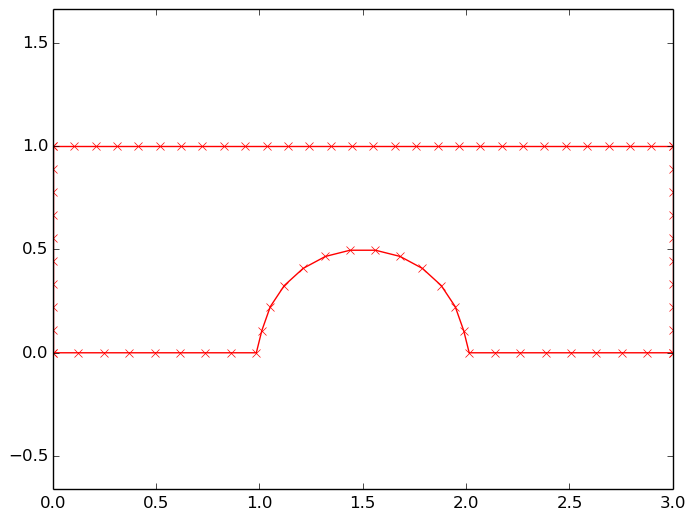

In [6]:
chx,chy = channel(30,10);
plot_boundary(chx,chy);

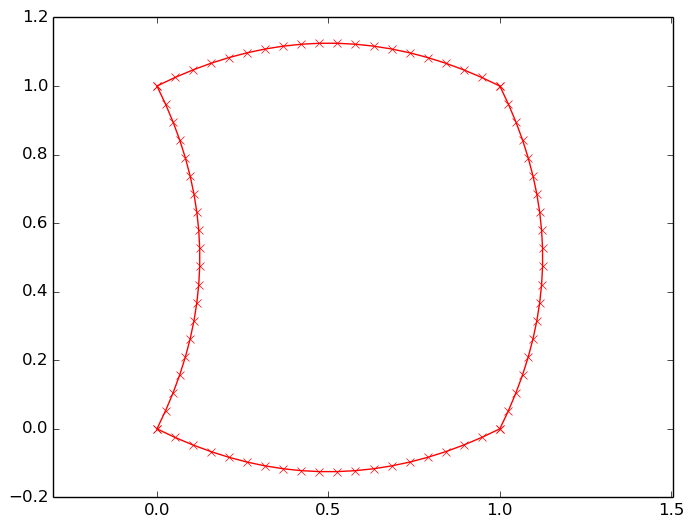

In [7]:
crx,cry = curved_rectangle(20,20);
plot_boundary(crx,cry);

## Algebraická síť 

### Jednosměrná interpolace

In [8]:
function straight_j!(x,y)
    n,m = size(x)
    for j = 2:m-1
        η = (j-1) / (m-1)
        x[2:n-1,j] = (1-η) * x[2:n-1,1] + η * x[2:n-1,end]
        y[2:n-1,j] = (1-η) * y[2:n-1,1] + η * y[2:n-1,end]
    end
end

straight_j! (generic function with 1 method)

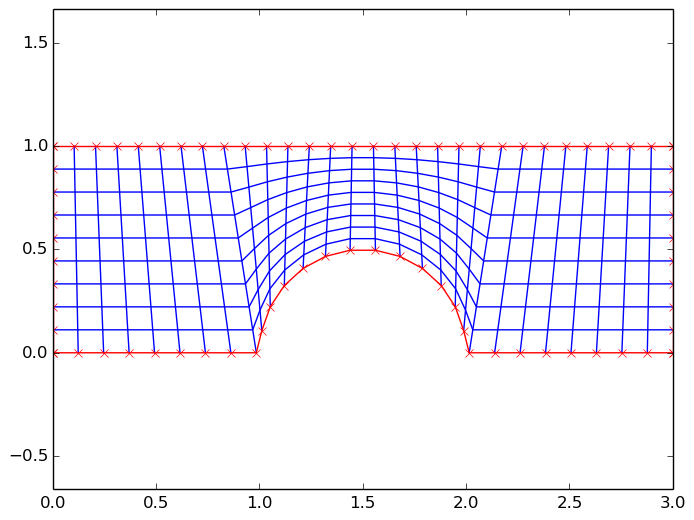

In [9]:
straight_j!(chx,chy);
plot_mesh(chx,chy);

In [10]:
plot_mesh(x,y)

LoadError: UndefVarError: x not defined

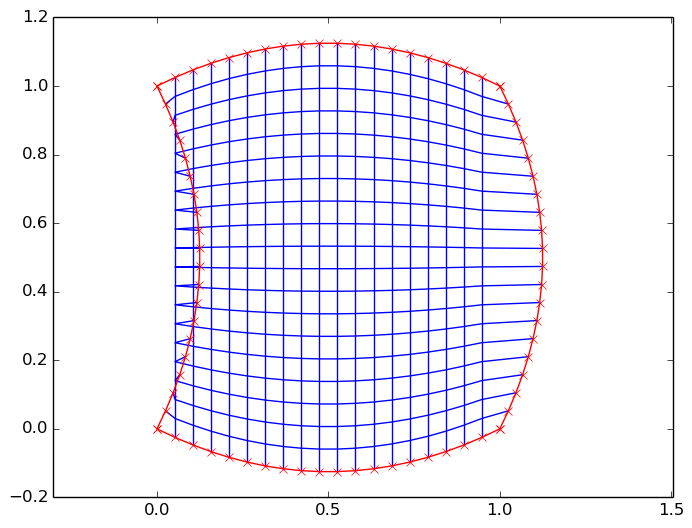

In [11]:
straight_j!(crx,cry);
plot_mesh(crx,cry);

### Transfinitní interpolace

In [12]:
function linear_tfi!(x,y)
    n,m = size(x)
    
    for i=2:n-1
        ξ = (i-1) / (n-1)
        for j=2:m-1
            η = (j-1) / (m-1)
            
            ux = (1-ξ) * x[1,j] + ξ * x[n,j]
            uy = (1-ξ) * y[1,j] + ξ * y[n,j]

            vx = (1-η) * x[i,1] + η * x[i,m]
            vy = (1-η) * y[i,1] + η * y[i,m]
            
            uvx = (1-ξ)*(1-η) * x[1,1] + ξ*(1-η) * x[n,1] + (1-ξ)*η * x[1,m] + ξ*η * x[n,m]
            uvy = (1-ξ)*(1-η) * y[1,1] + ξ*(1-η) * y[n,1] + (1-ξ)*η * y[1,m] + ξ*η * y[n,m]
            
            x[i,j] = ux + vx - uvx
            y[i,j] = uy + vy - uvy            
        end
    end
end

linear_tfi! (generic function with 1 method)

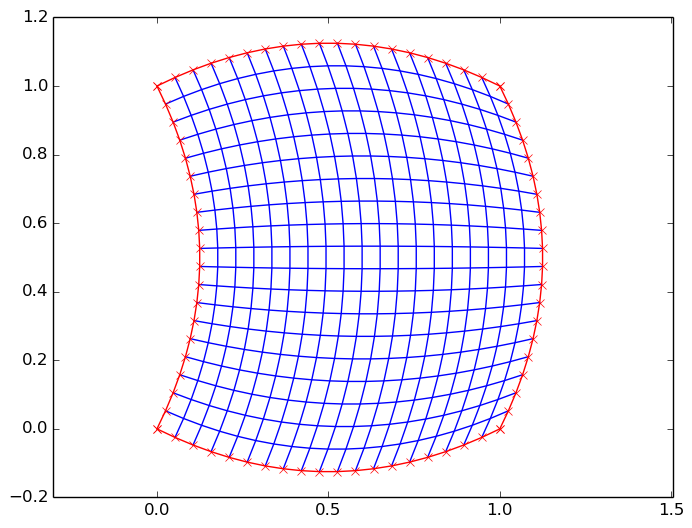

In [13]:
linear_tfi!(crx,cry);
plot_mesh(crx,cry);

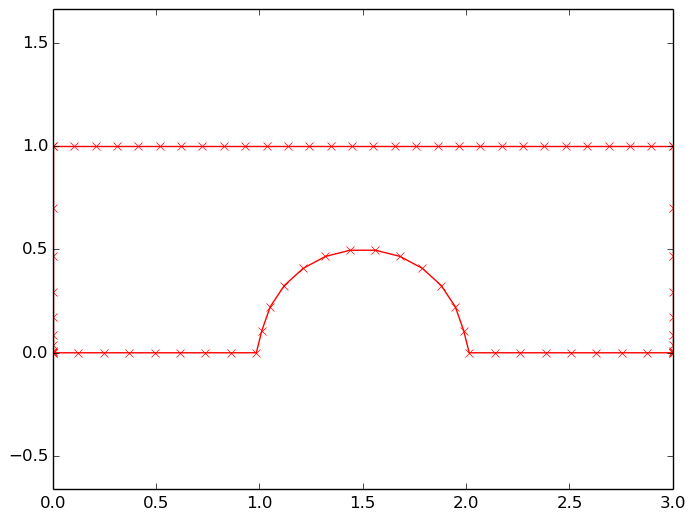

In [14]:
nsx,nsy = channel_ns(30,10);
plot_boundary(nsx,nsy);

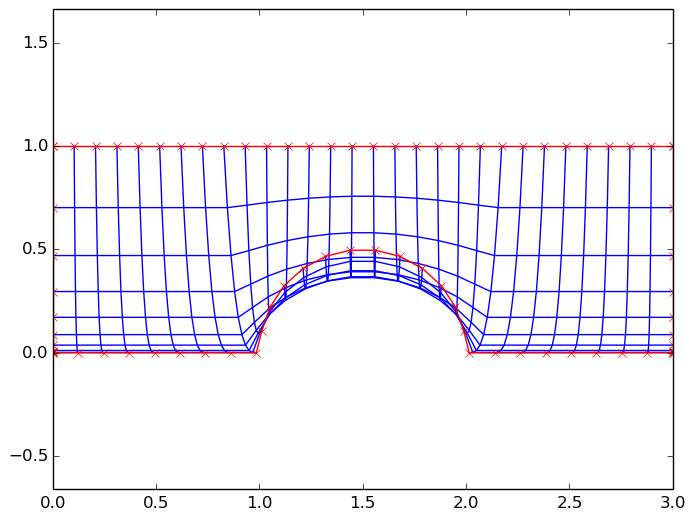

In [15]:
linear_tfi!(nsx,nsy);
plot_mesh(nsx,nsy);

## Eliptický generátor

\begin{align*}
    \Delta \xi(x,y) &= p(x,y), \\
    \Delta \eta(x,y) &= q(x,y) 
\end{align*}

* Transformace prvních derivací:
Mějme funkci $\phi(\xi(x,y), \eta(x,y))$ potom pro její parciální derivace platí 
\begin{align*}
    \phi_x &= \phi_\xi \xi_x + \phi_\eta \eta_x, \\
    \phi_y &= \phi_\xi \xi_y + \phi_\eta \eta_y.
\end{align*}

* Transformace druhých derivací:

\begin{align*}
    \phi_{xx} &= (\phi_{\xi\xi}\xi_x + \phi_{\xi\eta}\eta_x) \xi_x + \phi_\xi \xi_{xx} +
        (\phi_{\eta\xi}\xi_x + \phi_{\eta\eta}\eta_x) \eta_x + \phi_\eta \eta_{xx}, 
        \\
    \phi_{yy} &= (\phi_{\xi\xi}\xi_y + \phi_{\xi\eta}\eta_y) \xi_y + \phi_\xi \xi_{yy} +
        (\phi_{\eta\xi}\xi_y + \phi_{\eta\eta}\eta_y) \eta_y + \phi_\eta \eta_{yy}, 
\end{align*}

neboli

\begin{align*}
    \phi_{xx} &= \xi_x^2 \phi_{\xi\xi} + 2 \xi_x\eta_x \phi_{\xi\eta} + \eta_x^2 \phi_{\eta\eta} +  
        \xi_{xx} \phi_\xi +  \eta_{xx} \phi_\eta, 
        \\
    \phi_{yy} &= \xi_y^2 \phi_{\xi\xi} + 2 \xi_y\eta_y \phi_{\xi\eta} + \eta_y^2 \phi_{\eta\eta} +  
        \xi_{yy} \phi_\xi +  \eta_{yy} \phi_\eta. 
\end{align*}

Laplaceův operátor v křivočarých souřadnicích

$$
    \Delta \phi =
    (\nabla \xi \cdot \nabla \xi) \phi_{\xi\xi} +
    2(\nabla\xi\cdot\nabla\eta) \phi_{\xi\eta} + 
    (\nabla \eta \cdot \nabla \eta) \phi_{\eta\eta} + \Delta \xi \phi_\xi + \Delta \eta \phi_\eta
$$

Protože platí
$$
\begin{bmatrix}
\xi_x & \xi_y \\ \eta_x & \eta_y
\end{bmatrix} 
= 
\begin{bmatrix}
x_\xi & x_\eta \\ y_\xi & y_\eta
\end{bmatrix}^{-1}
= 
\frac{1}{J}
\begin{bmatrix}
y_\eta & - x_\eta \\ - y_\eta & x_\xi
\end{bmatrix},
$$
kde $J=x_\xi y_\eta - x_\eta y_\xi$, lze Laplaceův operátor vyjádřit jako

$$
    \Delta \phi =
    \frac{1}{J^2}(x_\eta^2+y_\eta^2) \phi_{\xi\xi} -
    \frac{2}{J^2}(x_\xi x_\eta + y_\xi y_\eta)\phi_{\xi\eta} + 
    \frac{1}{J^2}(x_\xi^2+y_\xi^2) \phi_{\eta\eta} + \Delta \xi \phi_\xi + \Delta \eta \phi_\eta
$$

Zvolíme-li nejprve $\phi=x$ a pak $\phi=y$ a rovnici násobíme $J^2$, dostaneme 
\begin{align*}
    0 &=(x_\eta^2+y_\eta^2) x_{\xi\xi} -
    2(x_\xi x_\eta + y_\xi y_\eta)x_{\xi\eta} + 
    (x_\xi^2+y_\xi^2) x_{\eta\eta} + J^2\Delta \xi x_\xi + J^2\Delta \eta x_\eta, \\
    0 &=(x_\eta^2+y_\eta^2) y_{\xi\xi} -
    2(x_\xi x_\eta + y_\xi y_\eta)y_{\xi\eta} + 
    (x_\xi^2+y_\xi^2) y_{\eta\eta} + J^2\Delta \xi y_\xi + J^2\Delta \eta y_\eta.
\end{align*}

Jestliže $\xi$ a $\eta$ splňují rovnice $\Delta \xi = p$ a $\Delta \eta = q$, lze výše uvedenou soustavu přepsat jako
$$
g_{22}(\vec{x}_{\xi\xi} + P \vec{x}_{\xi}) - 2 g_{12} \vec{x}_{\xi\eta} + g_{11}(\vec{x}_{\eta\eta}+Q \vec{x}_{\eta}) = 0,
$$
kde
\begin{align*}
    g_{11} &=\vec{x}_{\xi} \cdot \vec{x}_{\xi}, \\ 
    g_{12} &=\vec{x}_{\xi} \cdot \vec{x}_{\eta}, \\ 
    g_{22} &=\vec{x}_{\eta} \cdot \vec{x}_{\eta}, \\ 
    P &= \frac{J^2}{g_{22}} p, \\
    Q &= \frac{J^2}{g_{11}} q.    
\end{align*}

In [43]:
function elliptic_mesh!(x, y; P=(i,j)->0.0, Q=(i,j)->0.0, ϵ=1.e-4, maxiter=10000)
    n, m = size(x)
    
    linear_tfi!(x,y)       # Vytvoreni pocatecni site 
    
    err = Inf
    iter = 0
    
    while err > ϵ^2 && iter < maxiter
        iter = iter + 1
        err = 0.0
        for i=2:n-1, j=2:m-1
            x_ξ = (x[i+1,j] - x[i-1,j]) / 2.0
            y_ξ = (y[i+1,j] - y[i-1,j]) / 2.0
            x_η = (x[i,j+1] - x[i,j-1]) / 2.0
            y_η = (y[i,j+1] - y[i,j-1]) / 2.0
            
            g_11 = x_ξ^2 + y_ξ^2
            g_12 = x_ξ*x_η + y_ξ*y_η
            g_22 = x_η^2 + y_η^2

            x_ξη = ((x[i+1,j+1]-x[i-1,j+1])-(x[i+1,j-1]-x[i-1,j-1]))/4.0
            y_ξη = ((y[i+1,j+1]-y[i-1,j+1])-(y[i+1,j-1]-y[i-1,j-1]))/4.0

            x_new = ( g_22*(x[i+1,j]+x[i-1,j] + P(i,j)*x_ξ) - 2*g_12*x_ξη + 
            g_11*(x[i,j+1]+x[i,j-1] + Q(i,j)*x_η) ) / (2*g_11 + 2*g_22)

            y_new = ( g_22*(y[i+1,j]+y[i-1,j] + P(i,j)*y_ξ) - 2*g_12*y_ξη + 
            g_11*(y[i,j+1]+y[i,j-1] + Q(i,j)*y_η) ) / (2*g_11 + 2*g_22)

            err = err + (x[i,j]-x_new)^2 + (y[i,j]-y_new)^2

            x[i,j] = x_new
            y[i,j] = y_new
        end
        if iter % 10 == 0
            println("Iterace: ",iter, "\tchyba:", √err)
        end
    end
end

elliptic_mesh! (generic function with 5 methods)

In [44]:
elliptic_mesh!(crx,cry)

Iterace: 10	chyba:0.01668954311796517
Iterace: 20	chyba:0.011976786692384691
Iterace: 30	chyba:0.008950436734699798
Iterace: 40	chyba:0.006794888426867682
Iterace: 50	chyba:0.005197129330078732
Iterace: 60	chyba:0.003989654501510694
Iterace: 70	chyba:0.0030679773608053478
Iterace: 80	chyba:0.0023609180733222004
Iterace: 90	chyba:0.0018172319553960968
Iterace: 100	chyba:0.0013987689118860082
Iterace: 110	chyba:0.0010765929194948248
Iterace: 120	chyba:0.0008285486392860207
Iterace: 130	chyba:0.0006375993812898049
Iterace: 140	chyba:0.0004906225227006342
Iterace: 150	chyba:0.0003775057943068807
Iterace: 160	chyba:0.0002904573193368819
Iterace: 170	chyba:0.00022347473071732338
Iterace: 180	chyba:0.00017193551793263833
Iterace: 190	chyba:0.000132280729137623
Iterace: 200	chyba:0.00010177083059901461


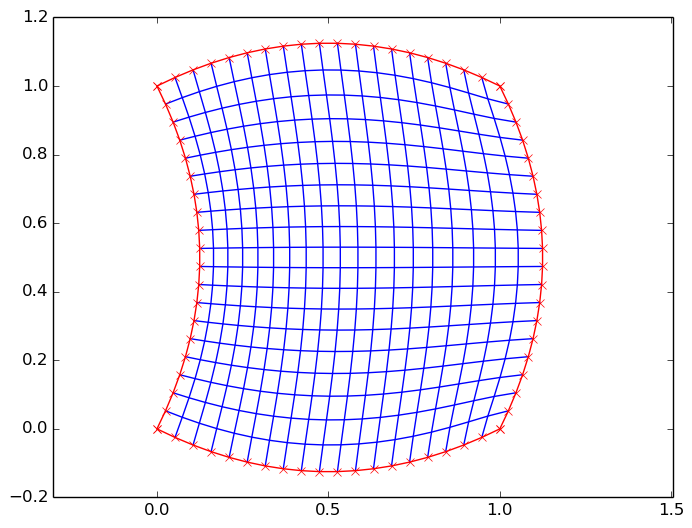

In [45]:
plot_mesh(crx,cry);

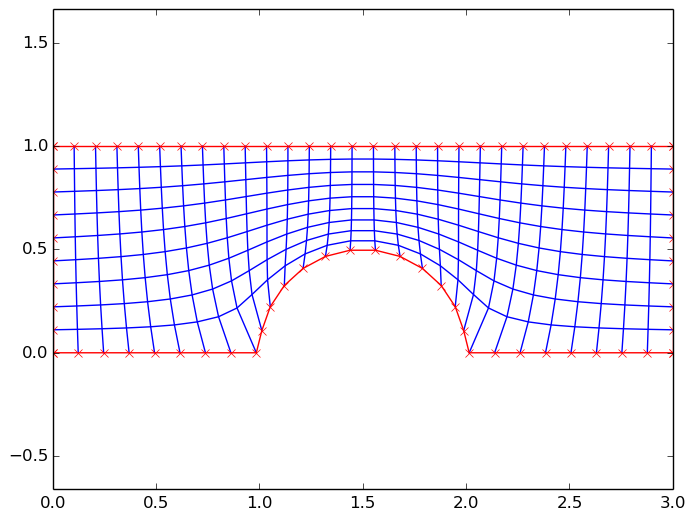

Iterace: 10	chyba:0.025293356720964624
Iterace: 20	chyba:0.009385314886533621
Iterace: 30	chyba:0.0037874461732360005
Iterace: 40	chyba:0.0015569793897105026
Iterace: 50	chyba:0.0006498131539460579
Iterace: 60	chyba:0.0002748559065607862
Iterace: 70	chyba:0.00011747797521457042


In [46]:
elliptic_mesh!(chx,chy)
plot_mesh(chx,chy);

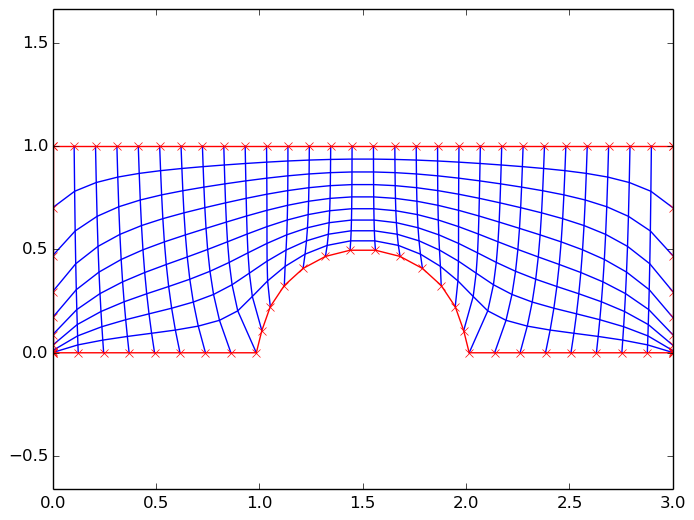

Iterace: 10	chyba:0.16092111136264267
Iterace: 20	chyba:0.07940273541750618
Iterace: 30	chyba:0.03746027910583134
Iterace: 40	chyba:0.017315006380582948
Iterace: 50	chyba:0.00791071642306324
Iterace: 60	chyba:0.0035852130739444225
Iterace: 70	chyba:0.0016153995220977864
Iterace: 80	chyba:0.0007247817301966351
Iterace: 90	chyba:0.0003241953229119983
Iterace: 100	chyba:0.00014469221117999803


In [47]:
elliptic_mesh!(nsx,nsy)
plot_mesh(nsx,nsy);

### Vliv zdrojových členů
* $P>0$ posouvá síťové čáry doprava 
* $P<0$ posouvá síťové čáry doleva 
* $Q>0$ posouvá síťové čáry nahoru
* $Q<0$ posouvá síťové čáry dolu 

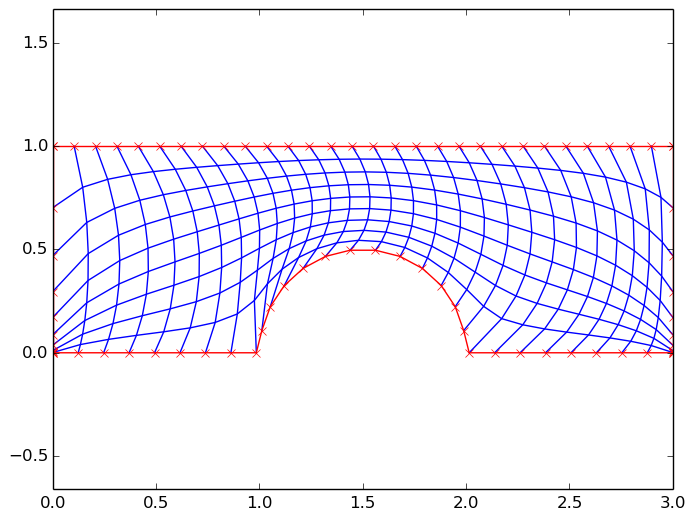

Iterace: 10	chyba:0.17375199471074412
Iterace: 20	chyba:0.08989610515668903
Iterace: 30	chyba:0.043068045545660204
Iterace: 40	chyba:0.01997648753441335
Iterace: 50	chyba:0.009135116383926657
Iterace: 60	chyba:0.004147701758580413
Iterace: 70	chyba:0.0018761691292760079
Iterace: 80	chyba:0.0008471647302170373
Iterace: 90	chyba:0.00038236256191139775
Iterace: 100	chyba:0.0001726733160354746


In [48]:
elliptic_mesh!(nsx,nsy, P=(i,j)->0.2);
plot_mesh(nsx,nsy);

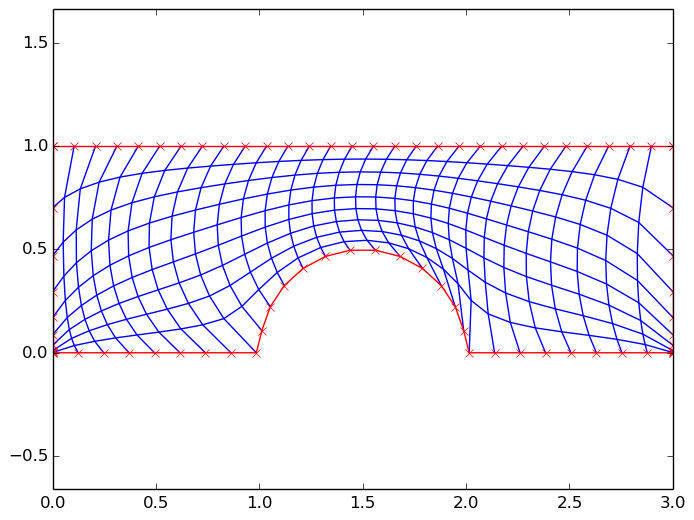

Iterace: 10	chyba:0.1755002910442758
Iterace: 20	chyba:0.08402495955418571
Iterace: 30	chyba:0.03865094648724551
Iterace: 40	chyba:0.017581215915142338
Iterace: 50	chyba:0.00798303695176473
Iterace: 60	chyba:0.003628543363971947
Iterace: 70	chyba:0.001654405741389771
Iterace: 80	chyba:0.0007585361425889591
Iterace: 90	chyba:0.00035069708184549064
Iterace: 100	chyba:0.00016389227756617974


In [49]:
elliptic_mesh!(nsx,nsy, P=(i,j)-> -0.2);
plot_mesh(nsx,nsy);

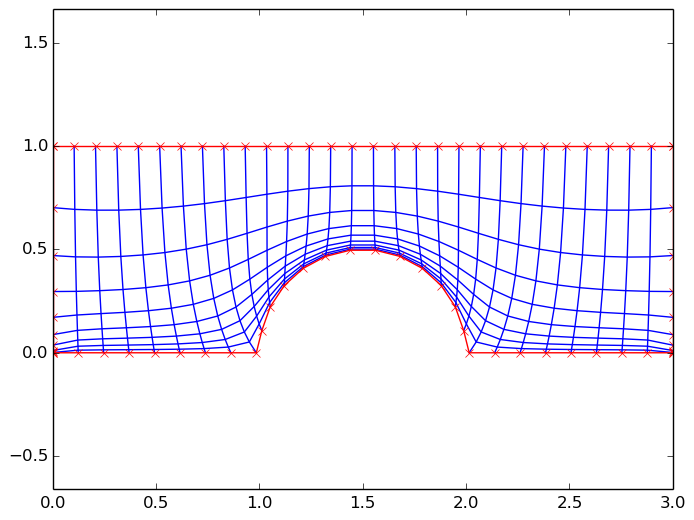

Iterace: 10	chyba:0.046579327811902584
Iterace: 20	chyba:0.016386461886536276
Iterace: 30	chyba:0.00640165427568741
Iterace: 40	chyba:0.0025341871647283983
Iterace: 50	chyba:0.0009844864083671677
Iterace: 60	chyba:0.00037423037170638786
Iterace: 70	chyba:0.0001398792094961873


In [51]:
elliptic_mesh!(nsx,nsy, Q=(i,j)->-0.4);
plot_mesh(nsx,nsy);

### Automatická volba P a Q (kolmost na hranici + velikost první buňky)

* vytvoříme body v první vrstvě s požadovanou vzdáleností a kolmostí na hranici
* z rovnice určíme P a Q na hranici
* provedeme transfinitní interpolaci P a Q do vnitřku oblasti
* vygenerujeme síť